# Analysis of the Project CSV Data

## Load Data from CSV and Initialize

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

projects = pd.read_csv('result/JavaProjectSample.csv')

# Drop data with < 100 of code, and no commits
projects = projects[projects['commits'] > 0]
projects = projects[projects['lines_of_code'] > 100]
projects = projects[projects['src_file_size'] > 0]

projects['comment_density'] = projects['lines_of_comments'] / projects['lines_of_code']
projects['comment_portion'] = projects['comment_size'] / projects['src_file_size']
projects['comments'] = projects['doc_comment'] + projects['impl_comment']
projects['comment_per_file'] = projects['comments'] / projects['src_files']
projects['doc_comment_per_file'] = projects['doc_comment'] / projects['src_files']
projects['impl_comment_per_file'] = projects['impl_comment'] / projects['src_files']
projects['popularity'] = [('High' if x >= 1000 else ('Mid' if x >= 100 else 'Low')) for x in projects['stars']]

sns.set(style='white')

projects.describe()

,size,stars,watchers,forks,commits,authors,lines_of_code,lines_of_comments,lines_blank,src_files,src_file_size,comment_size,doc_comment,impl_comment,comment_density,comment_portion,comments,comment_per_file,doc_comment_per_file,impl_comment_per_file
count,8.870000e+02,887.000000,887.000000,887.000000,887.000000,887.000000,8.870000e+02,8.870000e+02,8.870000e+02,887.000000,8.870000e+02,8.870000e+02,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000
mean,7.749039e+04,1598.199549,1598.199549,539.139797,5941.121759,133.555806,1.072550e+05,4.074207e+04,2.178048e+04,1028.649380,6.270337e+06,1.676637e+06,3993.346110,7607.099211,0.324380,0.215971,11600.445321,9.736894,3.109440,6.627454
std,1.791800e+05,4002.397714,4002.397714,1431.237803,21487.526445,242.002138,2.995368e+05,1.805191e+05,6.180781e+04,2735.188603,1.978542e+07,7.548992e+06,16497.319686,28258.012471,0.244137,0.118963,40944.658434,11.938294,3.334604,10.420271
min,4.620000e+02,0.000000,0.000000,0.000000,502.000000,1.000000,1.020000e+02,4.000000e+00,2.100000e+01,4.000000,2.807000e+03,1.710000e+02,0.000000,2.000000,0.000815,0.003124,7.000000,0.121951,0.000000,0.024643
25%,5.956000e+03,15.500000,15.500000,11.000000,920.000000,23.000000,1.178350e+04,2.589000e+03,2.501000e+03,141.500000,6.373885e+05,9.695050e+04,227.000000,485.000000,0.164705,0.129808,785.000000,3.998846,1.077835,2.517590
50%,2.072600e+04,304.000000,304.000000,111.000000,1945.000000,62.000000,2.948900e+04,8.057000e+03,6.314000e+03,354.000000,1.633251e+06,3.106990e+05,720.000000,1404.000000,0.280677,0.213309,2368.000000,6.738908,2.168142,4.326531
75%,6.833100e+04,1457.000000,1457.000000,455.000000,4741.000000,148.000000,8.319450e+04,2.630500e+04,1.686100e+04,886.500000,4.495258e+06,1.018200e+06,2388.500000,4587.500000,0.435671,0.289864,7319.500000,11.791077,4.033851,7.561177
max,2.389684e+06,48989.000000,48989.000000,19706.000000,550545.000000,3972.000000,5.015770e+06,4.358214e+06,1.089598e+06,52755.000000,3.526416e+08,1.823837e+08,351684.000000,509233.000000,3.156340,0.708274,651398.000000,227.800000,38.931818,222.718868


## Display the Differences of three Popularity Types

In [2]:
projects[projects['popularity']=='High'].describe()

,size,stars,watchers,forks,commits,authors,lines_of_code,lines_of_comments,lines_blank,src_files,src_file_size,comment_size,doc_comment,impl_comment,comment_density,comment_portion,comments,comment_per_file,doc_comment_per_file,impl_comment_per_file
count,2.980000e+02,298.000000,298.000000,298.000000,298.000000,298.000000,2.980000e+02,2.980000e+02,2.980000e+02,298.000000,2.980000e+02,2.980000e+02,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,8.528003e+04,4386.442953,4386.442953,1437.063758,7692.244966,239.302013,1.369093e+05,5.993281e+04,2.950829e+04,1375.476510,8.442797e+06,2.496733e+06,5820.778523,9817.036913,0.357406,0.238253,15637.815436,10.052460,3.440332,6.612128
std,1.599174e+05,5993.962445,5993.962445,2203.156966,14167.708693,281.073404,3.983585e+05,2.767413e+05,9.021021e+04,4021.190647,2.837652e+07,1.162575e+07,24222.650672,34841.956477,0.225939,0.111388,53813.414222,8.775907,3.079232,7.023533
min,7.920000e+02,1002.000000,1002.000000,114.000000,504.000000,1.000000,7.990000e+02,6.800000e+01,2.120000e+02,5.000000,3.318800e+04,3.200000e+03,2.000000,50.000000,0.029790,0.024533,53.000000,0.548490,0.030822,0.387097
25%,7.168750e+03,1453.000000,1453.000000,405.250000,1358.250000,71.000000,1.808250e+04,3.971500e+03,3.703500e+03,196.000000,9.391550e+05,1.529072e+05,386.000000,740.750000,0.191725,0.152942,1200.750000,4.764651,1.450756,2.924790
50%,2.333450e+04,2358.500000,2358.500000,740.500000,2850.000000,147.000000,3.779100e+04,1.093700e+04,8.485500e+03,444.000000,2.174468e+06,4.307455e+05,1050.000000,1928.000000,0.316992,0.236177,3289.000000,7.796648,2.548537,4.690379
75%,9.309775e+04,4446.000000,4446.000000,1596.750000,6688.000000,292.500000,9.696575e+04,3.661525e+04,2.296225e+04,1168.000000,5.857358e+06,1.604076e+06,3137.750000,6103.750000,0.464292,0.309811,9422.500000,12.510491,4.268017,7.798592
max,1.297414e+06,48989.000000,48989.000000,19706.000000,103503.000000,1902.000000,5.015770e+06,4.358214e+06,1.089598e+06,52755.000000,3.526416e+08,1.823837e+08,351684.000000,509233.000000,1.258413,0.616076,651398.000000,89.481203,21.851274,77.926692


In [3]:
projects[projects['popularity']=='Mid'].describe()

,size,stars,watchers,forks,commits,authors,lines_of_code,lines_of_comments,lines_blank,src_files,src_file_size,comment_size,doc_comment,impl_comment,comment_density,comment_portion,comments,comment_per_file,doc_comment_per_file,impl_comment_per_file
count,2.950000e+02,295.000000,295.000000,295.000000,295.000000,295.000000,2.950000e+02,2.950000e+02,295.000000,295.000000,2.950000e+02,2.950000e+02,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000
mean,7.981595e+04,362.461017,362.461017,159.552542,6614.528814,83.501695,1.019820e+05,3.253414e+04,18566.708475,907.447458,5.635761e+06,1.333128e+06,3073.583051,7463.613559,0.310191,0.214058,10537.196610,9.616502,3.037292,6.579210
std,1.805789e+05,228.943591,228.943591,165.378754,33782.542941,118.991421,2.548159e+05,9.255194e+04,36186.338035,1784.945498,1.339806e+07,3.634242e+06,9676.753478,27754.811013,0.215383,0.114548,35592.275289,9.352942,3.735648,6.949730
min,7.730000e+02,101.000000,101.000000,9.000000,509.000000,2.000000,4.720000e+02,4.500000e+01,114.000000,8.000000,2.520800e+04,1.973000e+03,0.000000,18.000000,0.005823,0.011104,23.000000,0.523944,0.000000,0.024643
25%,6.182000e+03,173.500000,173.500000,56.000000,898.500000,23.500000,1.215450e+04,2.408000e+03,2665.000000,145.500000,6.871230e+05,9.625900e+04,196.000000,529.500000,0.164302,0.131825,768.500000,3.888109,1.000313,2.511923
50%,1.997200e+04,300.000000,300.000000,104.000000,1821.000000,54.000000,2.978600e+04,8.460000e+03,6122.000000,373.000000,1.581342e+06,3.341460e+05,755.000000,1453.000000,0.280677,0.213809,2371.000000,6.738908,2.050459,4.326531
75%,6.767400e+04,511.500000,511.500000,201.000000,4269.500000,105.000000,8.340650e+04,2.694100e+04,16549.500000,797.500000,4.414390e+06,1.023960e+06,2244.000000,4592.000000,0.429526,0.283694,7379.500000,11.683943,4.030825,8.164421
max,1.791347e+06,998.000000,998.000000,1297.000000,550545.000000,1594.000000,2.922057e+06,1.056697e+06,261961.000000,13195.000000,1.353158e+08,3.820567e+07,127014.000000,334169.000000,1.606362,0.625105,401555.000000,72.901515,38.931818,49.764402


In [4]:
projects[projects['popularity']=='Low'].describe()

,size,stars,watchers,forks,commits,authors,lines_of_code,lines_of_comments,lines_blank,src_files,src_file_size,comment_size,doc_comment,impl_comment,comment_density,comment_portion,comments,comment_per_file,doc_comment_per_file,impl_comment_per_file
count,2.940000e+02,294.000000,294.000000,294.000000,294.000000,294.000000,2.940000e+02,2.940000e+02,294.000000,294.000000,2.940000e+02,2.940000e+02,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,6.726131e+04,11.962585,11.962585,9.877551,3490.476190,76.595238,8.248802e+04,2.952607e+04,17172.227891,798.717687,4.705055e+06,1.190062e+06,3063.942177,5511.068027,0.305141,0.195304,8575.010204,9.537837,2.846440,6.691397
std,1.956236e+05,20.915774,20.915774,22.000744,6160.443732,256.232355,2.091984e+05,1.083743e+05,43549.268667,1686.621837,1.340658e+07,4.585503e+06,11365.114902,20043.285440,0.283294,0.126945,28913.570442,16.278018,3.134421,15.161350
min,4.620000e+02,0.000000,0.000000,0.000000,502.000000,1.000000,1.020000e+02,4.000000e+00,21.000000,4.000000,2.807000e+03,1.710000e+02,0.000000,2.000000,0.000815,0.003124,7.000000,0.121951,0.000000,0.027451
25%,4.405750e+03,0.000000,0.000000,0.000000,747.750000,11.000000,8.377500e+03,1.367000e+03,1721.000000,115.000000,4.125848e+05,4.774475e+04,134.000000,303.750000,0.131239,0.099834,509.500000,3.503606,0.819870,2.079425
50%,1.844500e+04,2.000000,2.000000,1.000000,1227.500000,27.500000,2.383000e+04,4.947500e+03,4701.000000,271.500000,1.177037e+06,1.756025e+05,489.500000,855.500000,0.246099,0.180695,1677.000000,6.077853,1.831721,4.021102
75%,5.787050e+04,15.000000,15.000000,11.000000,3538.000000,59.750000,6.511700e+04,1.708075e+04,13097.750000,753.500000,3.297772e+06,6.461492e+05,1567.500000,3163.500000,0.416728,0.279952,4262.500000,11.117479,3.548891,6.736628
max,2.389684e+06,96.000000,96.000000,196.000000,48633.000000,3972.000000,2.380017e+06,1.534272e+06,439556.000000,16906.000000,1.723827e+08,6.758676e+07,143433.000000,280254.000000,3.156340,0.708274,371689.000000,227.800000,18.871795,222.718868


## Utility Functions

In [5]:
def analyze_correlation(x, y, types, ax):
    type_set = set(types)
    corr = {}
    corr['Overall'] = np.corrcoef(x, y)[0][1]
    for t in type_set:
        x1 = [val for idx, val in x.items() if types[idx] == t]
        y1 = [val for idx, val in y.items() if types[idx] == t]
        corr[t] = np.corrcoef(x1, y1)[0][1]
    sns.scatterplot(x, y, hue=types, ax=ax)
    print(corr)

def ranksum_test(x, y, types):
    samples = {}
    pvalues = {}
    means = {}
    for t in types:
        pvalues[t] = {}
        means[t] = {}
        samples[t] = 0
    for s in samples:
        samples[s] = projects[projects[y] == s][x]
        means[s]['Mean'] = np.mean(samples[s])
    for t1 in types:
        for t2 in types:
            statistics, pvalue = stats.ranksums(samples[t1], samples[t2])
            pvalues[t1][t2] = pvalues[t2][t1] = pvalue
    print('Rank-sum Test of {} and {}:'.format(x, y))
    print(pd.DataFrame.from_dict(means))
    print(pd.DataFrame.from_dict(pvalues))

## Comment Density Analysis

In [6]:
ranksum_test('comment_density', 'popularity', ['High', 'Mid', 'Low'])

Rank-sum Test of comment_density and popularity:
          High       Mid       Low
Mean  0.357406  0.310191  0.305141
          High       Mid       Low
High  1.000000  0.008773  0.000053
Mid   0.008773  1.000000  0.133803
Low   0.000053  0.133803  1.000000


In [7]:
ranksum_test('comment_portion', 'popularity', ['High', 'Mid', 'Low'])

Rank-sum Test of comment_portion and popularity:
          High       Mid       Low
Mean  0.238253  0.214058  0.195304
              High       Mid           Low
High  1.000000e+00  0.013575  5.700494e-07
Mid   1.357496e-02  1.000000  1.275431e-02
Low   5.700494e-07  0.012754  1.000000e+00


In [8]:
ranksum_test('doc_comment_per_file', 'popularity', ['High', 'Mid', 'Low'])

Rank-sum Test of doc_comment_per_file and popularity:
          High       Mid      Low
Mean  3.440332  3.037292  2.84644
          High       Mid       Low
High  1.000000  0.001411  0.000018
Mid   0.001411  1.000000  0.248800
Low   0.000018  0.248800  1.000000


In [9]:
ranksum_test('impl_comment_per_file', 'popularity', ['High', 'Mid', 'Low'])

Rank-sum Test of impl_comment_per_file and popularity:
          High      Mid       Low
Mean  6.612128  6.57921  6.691397
          High       Mid       Low
High  1.000000  0.193165  0.001512
Mid   0.193165  1.000000  0.059792
Low   0.001512  0.059792  1.000000


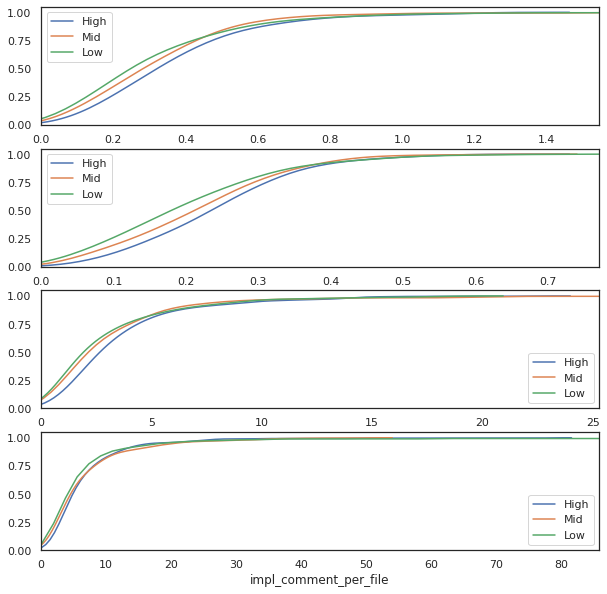

In [10]:
dims = ['comment_density', 'comment_portion', 'doc_comment_per_file', 'impl_comment_per_file']
fig, axes = plt.subplots(len(dims), 1)
fig.set_size_inches(10, 10)
for i, d in enumerate(dims):
    labels = ['High', 'Mid', 'Low']
    for label in labels:
        data = projects[projects['popularity'] == label][d]
        sns.distplot(data, hist=False, label=label, ax=axes[i], kde_kws=dict(cumulative=True))
        axes[i].set_xlim(left=0)

('lines_of_code', 'lines_of_comments'): {'Overall': 0.8777442899959237, 'Low': 0.84504661752268, 'High': 0.908898984092056, 'Mid': 0.8780042731671406}
('lines_of_code', 'comment_density'): {'Overall': 0.08617332092051083, 'Low': 0.03010219515073991, 'High': 0.09460419256897357, 'Mid': 0.09472853783554683}
('stars', 'comment_density'): {'Overall': 0.08890610836480158, 'Low': -0.03962070805463398, 'High': -0.03553625037511356, 'Mid': 0.056365958336402906}
('commits', 'comment_density'): {'Overall': 0.09073242424934382, 'Low': 0.058770985732442556, 'High': 0.07326601043189311, 'Mid': 0.06624369987825729}
('size', 'comment_density'): {'Overall': 0.02161970311006696, 'Low': -0.06123148652934012, 'High': 0.08806978192491596, 'Mid': 0.019909198757700225}
('authors', 'comment_density'): {'Overall': 0.12552750073431698, 'Low': 0.11850363405130238, 'High': 0.07648716963147856, 'Mid': 0.024588885022507292}
('forks', 'comment_density'): {'Overall': 0.11618821564899597, 'Low': -0.01620976996459381,

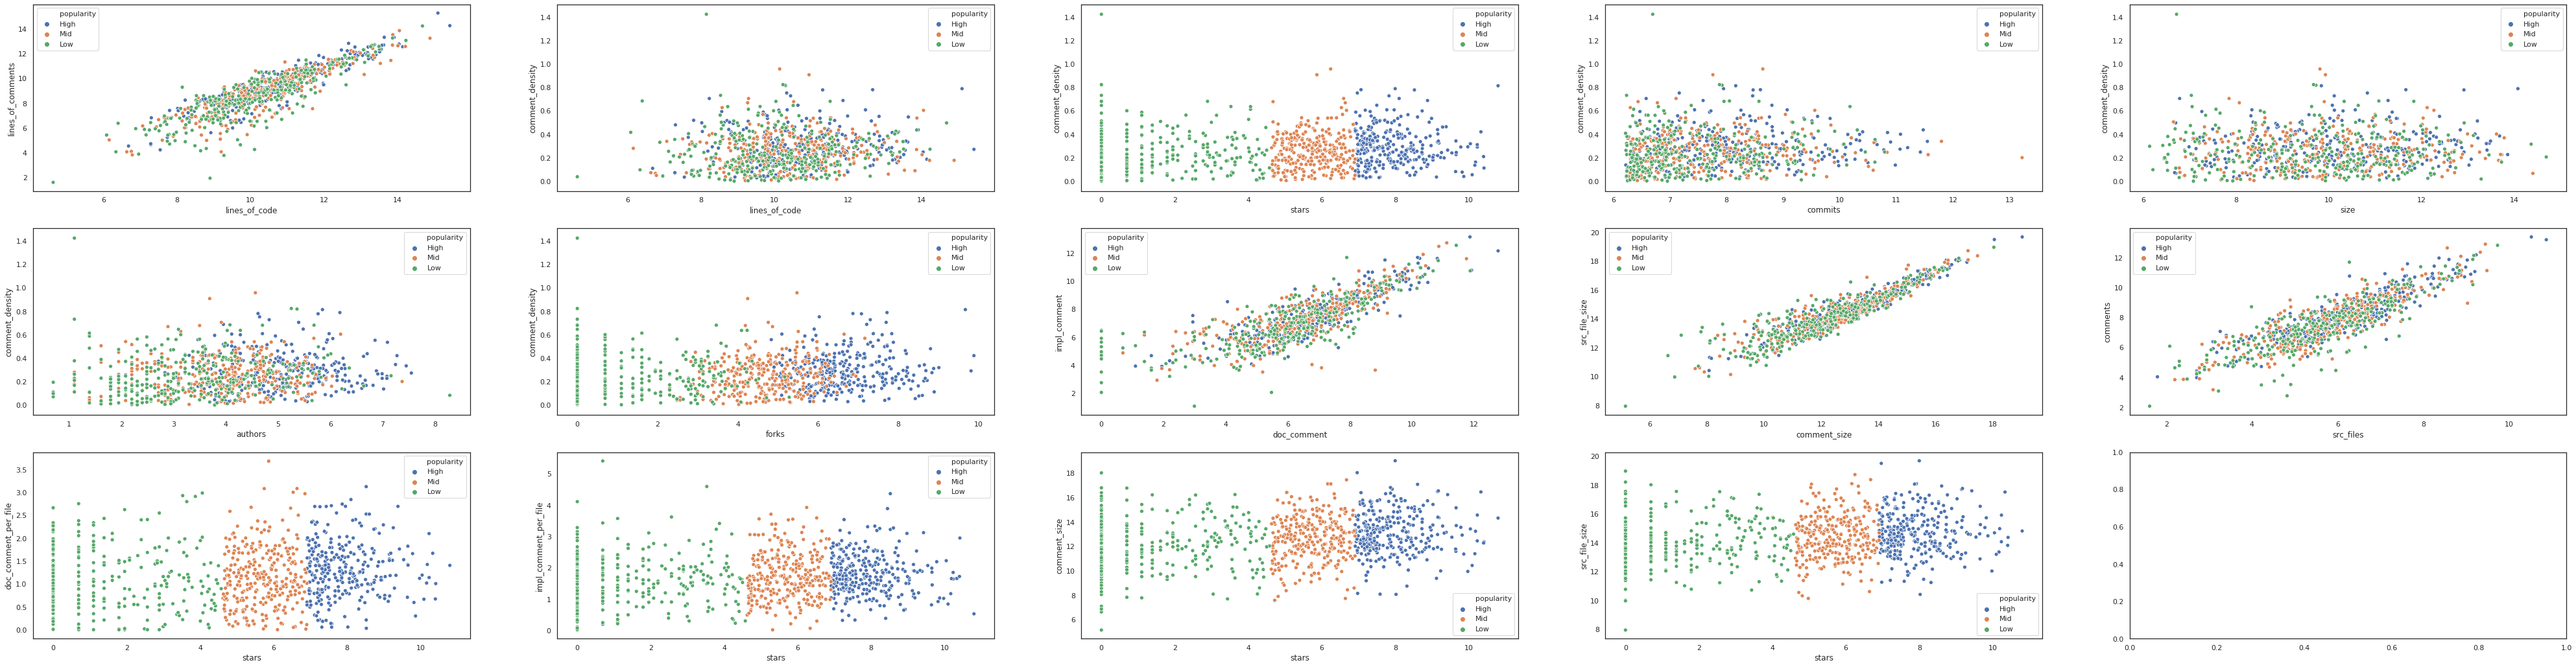

In [11]:
pairs = [('lines_of_code', 'lines_of_comments'),
        ('lines_of_code', 'comment_density'),
        ('stars', 'comment_density'),
        ('commits', 'comment_density'),
        ('size', 'comment_density'),
        ('authors', 'comment_density'),
        ('forks', 'comment_density'),
        ('doc_comment', 'impl_comment'),
        ('comment_size', 'src_file_size'),
        ('src_files', 'comments'),
        ('stars', 'doc_comment_per_file'),
        ('stars', 'impl_comment_per_file'),
        ('stars', 'comment_size'),
        ('stars', 'src_file_size')]
fig, axes = plt.subplots(len(pairs) // 5 + 1, 5)
fig.set_size_inches(5 * len(pairs), 6 * (len(pairs) // 5 + 1))
for i in range(0, len(pairs)):
    print(pairs[i], end=': ')
    analyze_correlation(x=np.log1p(projects[pairs[i][0]]), y=np.log1p(projects[pairs[i][1]]), types=projects['popularity'], ax=axes[i // 5][i % 5])
plt.savefig('temp/corr.pdf')

Some conclusions:
1. Popular open source projects tend to have slightly more comments in terms of both lines of comments, number of comments and length of comments. However, the overall effect is minor for many possible reasons, which calls for further analysis.
2. Popular open source projects tend to have more documentation comments, which means that either a project become popular because they are more properly documented, or popular projects need more documentation as more and more people participate in them. However, such phenomemon can not be observed on implementation comments.